In [1]:
import numpy as np
import matplotlib.pyplot as plt


## Loading data

In [2]:
from coco_utils import load_coco_data, load_coco_data_struct, sample_coco_minibatch, decode_captions
from image_utils import image_from_url


In [3]:
vocab_data, train_data, _  = load_coco_data_struct() # igore actual coco val set
val_data, train_data = train_data.split(0.3) # split further into train/val


Loaded vocab data.
Embedding <class 'numpy.ndarray'> (1004, 304) float64
Word to index <class 'dict'> 1004
Index to word <class 'list'> 1004

Loaded train data.
Captions <class 'numpy.ndarray'> (400135, 17) int32
Image indices <class 'numpy.ndarray'> (400135,) int32
Image features <class 'numpy.ndarray'> (82783, 4096) float32
Image urls <class 'numpy.ndarray'> (82783,) <U63

Loaded val data.
Captions <class 'numpy.ndarray'> (195954, 17) int32
Image indices <class 'numpy.ndarray'> (195954,) int32
Image features <class 'numpy.ndarray'> (40504, 4096) float32
Image urls <class 'numpy.ndarray'> (40504,) <U63

Splitting train data with ratio 0.3

Loaded train data.
Captions <class 'numpy.ndarray'> (120040, 17) int32
Image indices <class 'numpy.ndarray'> (120040,) int32
Image features <class 'numpy.ndarray'> (82783, 4096) float32
Image urls <class 'numpy.ndarray'> (82783,) <U63

Loaded train data.
Captions <class 'numpy.ndarray'> (280095, 17) int32
Image indices <class 'numpy.ndarray'> (2800

In [4]:
def sample_image(coco_data, batch_size):
    captions, features, urls = coco_data.sample(batch_size)
    show_image_caption(captions, features, urls)

def show_image_by_data_idx(coco_data, data_idx):
    captions, features, urls = coco_data.get(data_idx)
    show_image_caption(captions, features, urls)

def show_image_caption(captions, features, urls):
    for i, (caption, url) in enumerate(zip(captions, urls)):
        plt.imshow(image_from_url(url))
        plt.axis('off')
        caption_str = vocab_data.decode_captions(caption)
        plt.title(caption_str)
        plt.show()

def show_image_by_image_idxs(coco_data, img_idxs):
    """
        data indices to find image
    """
    urls = coco_data.get_urls_by_image_index(img_idxs)
    for url in urls:
        plt.imshow(image_from_url(url))
        plt.axis('off')
        plt.show()

In [5]:
def group_data_idx_by_image_idx(image_ids_in_caption_data_order):
    """
        Group image index, which is the same index position as corresponding caption data, by image id.
        i.e {8731 : [0,60,99,305]} caption and image features at these 4 positions correspond to image id 8731
    """
    image_positions_by_image_id = {}
    for i, img_id in enumerate(image_ids_in_caption_data_order):
        if img_id in image_positions_by_image_id:
            image_positions_by_image_id[img_id].append(i)
        else:
            image_positions_by_image_id[img_id] = [i]
    return image_positions_by_image_id

def map_grouped_data_index_to_grouped_captions(caption_data, grouped_image_index):
    """
        For each image id "key", get its corresponding captions, retrieved by "value" of the image instance indices.
        Image instance indices is assumed to be in the same order as the caption data.
    """
    captions_by_image_id = {}
    for k, v in grouped_image_index.items():
        captions_by_image_id[k] = caption_data[v]
    return captions_by_image_id

def scramble_image_caption_pairs(caption_data, grouped_image_index):    
    to_shuffle_caption = np.copy(caption_data)
    np.random.shuffle(to_shuffle_caption)
    return map_grouped_data_index_to_grouped_captions(to_shuffle_caption, grouped_image_index)

def flatten_image_caption_groups(grouped_captions):
    all_captions = []
    all_image_ids = []
    for k, v in grouped_captions.items():
        all_image_ids += [k] * len(v) # duplicate lables
        all_captions.append(v)
    flat_image_ids = np.array(all_image_ids)
    flat_captions = np.concatenate(all_captions, axis=0)
    assert flat_image_ids.shape[0] == flat_captions.shape[0]
    return flat_image_ids, flat_captions

def merge_demo_sampled(demo_image, demo_caption, sampled_image, sampled_caption):
    is_demo = np.ones(demo_image.shape)
    is_sample = np.ones(sampled_image.shape) * -1
    return np.concatenate([demo_image, sampled_image], axis=0), np.concatenate([demo_caption, sampled_caption], axis=0), np.concatenate([is_demo, is_sample], axis=0)



In [6]:
# minibatch
class MiniBatcher(object):
    def __init__(self, batchable_tuple):
        shapes = [b.shape[0] for b in batchable_tuple]
        assert all([s == shapes[0] for s in shapes]), "Data to be batched together should have the same first dimension"
        self.batchable_tuple = batchable_tuple
        self.data_size = shapes[0]
    
    def sample(self, batch_size=100):
        assert batch_size <= self.data_size
        mask = np.random.choice(self.data_size, batch_size)
        batch_list = [b[mask] for b in self.batchable_tuple]
        return tuple(batch_list)
    
def create_demo_sampled_batcher(coco_data):
    # create random pairing
    grouped_data_index_by_image_idx = group_data_idx_by_image_idx(coco_data.image_idx)
    grouped_captions_by_image_idx = map_grouped_data_index_to_grouped_captions(coco_data.captions_in_word_idx, grouped_data_index_by_image_idx)
    scrambled_grouped_captions_by_image_idx = scramble_image_caption_pairs(coco_data.captions_in_word_idx, grouped_data_index_by_image_idx)

    # merge both, and retain flag
    image_idx_demo, captions_demo = flatten_image_caption_groups(grouped_captions_by_image_idx)
    image_idx_sampled, caption_sampled = flatten_image_caption_groups(scrambled_grouped_captions_by_image_idx)

    demo_batcher = MiniBatcher((image_idx_demo, captions_demo, np.ones(image_idx_demo.shape)))
    sample_batcher = MiniBatcher((image_idx_sampled, caption_sampled, np.zeros(image_idx_sampled.shape)))
    return demo_batcher, sample_batcher

def process_mini_batch(batcher1, batcher2, batch_size):
    image_idx_batch1, caption_batch1, demo_or_sampled_batch1 = batcher1.sample(batch_size)
    image_idx_batch2, caption_batch2, demo_or_sampled_batch2 = batcher2.sample(batch_size)
    image_idx_batch = np.concatenate([image_idx_batch1, image_idx_batch2], axis=0)
    caption_batch = np.concatenate([caption_batch1, caption_batch2], axis=0)    
    demo_or_sampled_batch = np.concatenate([demo_or_sampled_batch1, demo_or_sampled_batch2], axis=0)   
    return image_idx_batch, caption_batch, demo_or_sampled_batch


In [7]:
demo_batcher, sample_batcher = create_demo_sampled_batcher(train_data)
val_demo_batcher, val_sample_batcher = create_demo_sampled_batcher(val_data)

In [8]:
def examine_validation(batch_size=100, to_examine=True):
    image_idx_batch, caption_batch, demo_or_sampled_batch = process_mini_batch(val_demo_batcher, val_sample_batcher, batch_size)
    caption_batch = caption_batch[:,1:]
    loss, reward_per_token, mean_reward = run_validation(sess, discr, val_data, image_idx_batch, caption_batch, demo_or_sampled_batch)
    if to_examine:
        examine(val_data, image_idx_batch, caption_batch, reward_per_token, mean_reward)
    return loss

def assign_reward(sess, discr, coco_data, img_idxs, caption_sentences):
    captions = [c.split() for c in caption_sentences]
    image_feats_test = coco_data.get_image_features(img_idxs)
    caption_test = vocab_data.encode_captions(captions)
    loss, reward_per_token, mean_reward = run_test(sess, discr, image_feats_test, caption_test)
    examine(coco_data, img_idxs, caption_test, reward_per_token, mean_reward)
    return loss, reward_per_token, mean_reward

def run_validation(sess, discr, coco_data, img_idxs, caption_word_idx, demo_or_sampled_batch):
    image_feats = coco_data.get_image_features(img_idxs)
    discr.image_input.pre_feed(image_feats)
    discr.caption_input.pre_feed(caption_word_idx)
    discr.metadata_input.pre_feed(labels=demo_or_sampled_batch)
    loss, reward_per_token, mean_reward = discr.test(sess)
    return loss, reward_per_token, mean_reward
    
def run_test(sess, discr, img_feature_test, caption_test):
    discr.image_input.pre_feed(img_feature_test)
    discr.caption_input.pre_feed(caption_test)
    discr.metadata_input.pre_feed(labels=np.ones(img_feature_test.shape[0]))
    loss, reward_per_token, mean_reward = discr.test(sess)
    return loss, reward_per_token, mean_reward
                           
def examine(coco_data, chosen_img, chosen_caption, chosen_reward_per_token, chosen_mean_reward):
    for (img_idx, cap, r, me_r) in zip(chosen_img, chosen_caption, chosen_reward_per_token, chosen_mean_reward):
        print("Avg reward: ", me_r)
        show_image_by_image_idxs(coco_data, [img_idx])
        decoded = vocab_data.decode_captions(cap).split()
        for (i,j) in zip(decoded, r):
            print("{:<15} {}".format(i, j))

        print("- - - -")
    
def examine_batch_results(coco_data, demo_or_sample, image_id, caption_batch, reward_per_token, mean_reward):
    num_to_examine = 4

    def examine_sample(chosen):
        print(chosen)
        chosen_img = image_id[chosen]
        chosen_cap = caption_batch[chosen]
        chosen_reward_per_token = reward_per_token[chosen]
        chosen_mean_reward = mean_reward[chosen]
        
        examine(coco_data, chosen_img, chosen_cap, chosen_reward_per_token, chosen_mean_reward)
    
    print("DEMO RESULTS")    
    chosen = np.random.choice(np.where( demo_or_sampled_batch == 1 )[0], num_to_examine)
    examine_sample(chosen)
    print("\n\nSAMPLED RESULTS")
    chosen = np.random.choice(np.where( demo_or_sampled_batch == 0 )[0], num_to_examine)
    examine_sample(chosen)

def random_sentence():
    word_idxs = np.random.choice(np.arange(vocab_data.START_ID + 1, vocab_data.vocab_dim), np.random.randint(8,12))
    return vocab_data.decode_captions(np.array([word_idxs]))


## Model

In [9]:
import tensorflow as tf
from discriminator import CaptionInput, ImageInput, MetadataInput, Discriminator, LstmScalarRewardStrategy
import layer_utils

In [10]:
tf.reset_default_graph()
caption_input = CaptionInput(word_embedding_init=vocab_data.embedding(),null_id=vocab_data.NULL_ID)
image_input = ImageInput(image_feature_dim=train_data.image_feature_dim)
metadata_input = MetadataInput()
reward_config = LstmScalarRewardStrategy.RewardConfig(
    reward_scalar_transformer = lambda x: tf.nn.sigmoid(layer_utils.affine_transform(x, 1, 'hidden_to_reward'))
)
discr = Discriminator(caption_input, image_input, metadata_input, reward_config=reward_config, hidden_dim=512)

## Training

In [11]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [12]:
iter_num = 400
batch_size = 1000

train_losses = []
val_losses = []
for i in range(iter_num):
    
    image_idx_batch, caption_batch, demo_or_sampled_batch = process_mini_batch(
        demo_batcher, 
        sample_batcher,
        batch_size
    )
    caption_batch = caption_batch[:,1::]
    image_feats_batch = train_data.get_image_features(image_idx_batch)
    
    discr.caption_input.pre_feed(caption_word_ids=caption_batch)
    discr.image_input.pre_feed(image_features=image_feats_batch)
    discr.metadata_input.pre_feed(demo_or_sampled_batch)
    loss, m, me = discr.train(sess)
        
    train_losses.append(loss)
    if i % 20 ==0:
        print("iter {}, loss: {}".format(i, loss))
    
    if i % 5 ==0:
        val_loss = examine_validation(batch_size, to_examine=False)
        val_losses.append(val_loss)
    else:
        val_losses.append(val_losses[-1])
        


iter 0, loss: 2.3208409402286634e-05
iter 20, loss: -0.034956831485033035
iter 40, loss: -0.1029023751616478
iter 60, loss: -0.1392095983028412
iter 80, loss: -0.1609896570444107
iter 100, loss: -0.1685737520456314
iter 120, loss: -0.20148882269859314
iter 140, loss: -0.2165021002292633
iter 160, loss: -0.2367650419473648
iter 180, loss: -0.23419669270515442
iter 200, loss: -0.23764047026634216
iter 220, loss: -0.23823635280132294
iter 240, loss: -0.24261069297790527
iter 260, loss: -0.25316372513771057
iter 280, loss: -0.26129645109176636
iter 300, loss: -0.2652886211872101
iter 320, loss: -0.2653872072696686
iter 340, loss: -0.2583234906196594
iter 360, loss: -0.2761911153793335
iter 380, loss: -0.2672167420387268


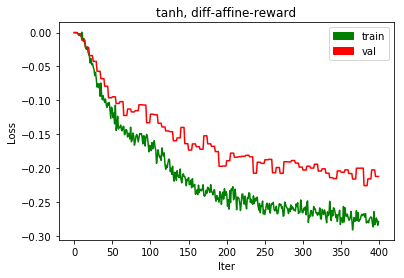

In [13]:
import matplotlib.patches as mpatches

plt.plot(np.arange(0, len(train_losses)), train_losses, 'g', val_losses, 'r')
train_loss_patch = mpatches.Patch(color='g', label='train')
val_loss_patch = mpatches.Patch(color='r', label='val')
plt.legend(handles=[train_loss_patch, val_loss_patch])
plt.ylabel('Loss')
plt.xlabel('Iter')
plt.title('tanh, diff-affine-reward')
plt.show()

DEMO RESULTS
[529 786 949 343]
Avg reward:  0.991123


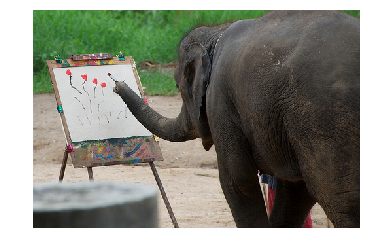

an              0.9999467134475708
elephant        0.9898031949996948
painting        0.9727547764778137
with            0.9979077577590942
a               0.9996904134750366
brush           0.9978678226470947
on              0.999505877494812
a               0.9994977712631226
piece           0.9502851366996765
of              0.997651994228363
paper           0.9885833263397217
<END>           0.9999871253967285
- - - -
Avg reward:  0.899296


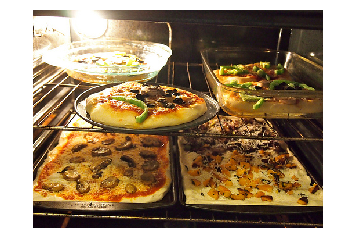

assorted        0.0003828211047220975
pizzas          0.9999607801437378
and             0.9998490810394287
baked           0.9997660517692566
dishes          0.9939363598823547
cooking         0.9992961883544922
in              0.999946117401123
an              0.9998995065689087
oven            0.999971866607666
<END>           0.9999552965164185
- - - -
Avg reward:  0.97953


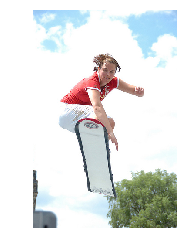

the             0.8801383972167969
person          0.9992079138755798
is              0.9873714447021484
<UNK>           0.9539062976837158
tricks          0.9961981177330017
on              0.9991170763969421
their           0.9998517036437988
board           0.9999799728393555
<END>           1.0
- - - -
Avg reward:  0.764839


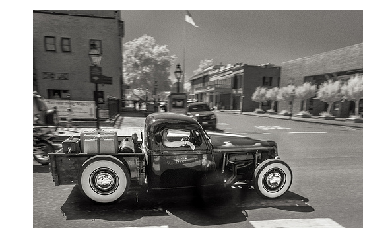

black           0.817137598991394
and             0.4762144982814789
white           0.6607493162155151
image           0.21407614648342133
of              0.2607020437717438
old             0.9861782789230347
antique         0.9999051094055176
<UNK>           0.9998632669448853
up              0.998475968837738
truck           0.9999353885650635
<END>           0.9999955892562866
- - - -


SAMPLED RESULTS
[1178 1303 1541 1961]
Avg reward:  0.0926327


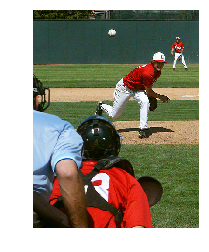

<UNK>           0.9306328296661377
<UNK>           0.0005226169596426189
in              0.03355862572789192
a               0.027494575828313828
<UNK>           0.008160349912941456
cup             0.0018008127808570862
with            0.0026831196155399084
two             0.012068456038832664
white           0.0009071675594896078
candles         0.0010038523469120264
<END>           0.00012698574573732913
- - - -
Avg reward:  0.999021


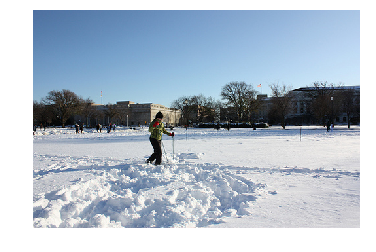

the             0.9999356269836426
herd            0.9989539384841919
of              0.999994158744812
elephants       0.999081015586853
is              0.9998924732208252
walking         0.9985253214836121
through         0.998522937297821
a               0.9972034692764282
<UNK>           0.9990298748016357
field           0.998288094997406
<END>           0.999808132648468
- - - -
Avg reward:  0.611048


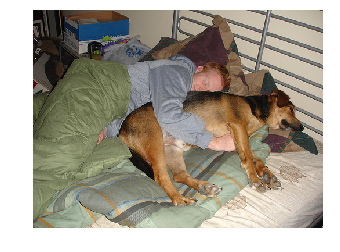

a               0.12728644907474518
man             0.9991713762283325
holding         0.9998254179954529
a               0.9994649291038513
red             0.9961339235305786
and             0.9973230957984924
black           0.9912002682685852
kite            2.3243492819347011e-07
<UNK>           6.955074786674231e-05
<END>           5.116002284921706e-06
- - - -
Avg reward:  0.000562591


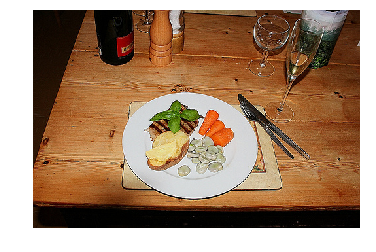

a               0.0003529628156684339
group           0.0008461027755402029
of              8.225058991229162e-05
people          4.1151994082611054e-05
ride            4.3746422306867316e-05
on              0.0002020257816184312
stand           0.00023307073570322245
up              0.0013311119982972741
<UNK>           0.0008163797901943326
boards          0.0019694308284670115
<END>           0.000270268035819754
- - - -


In [14]:
examine_batch_results(train_data, demo_or_sampled_batch, image_idx_batch, caption_batch, m, me)

Avg reward:  0.889015


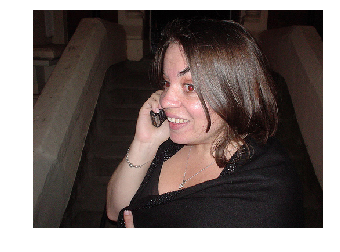

a               0.009783696383237839
young           0.9993067979812622
smiling         0.999992847442627
woman           0.9998063445091248
on              0.993720531463623
the             0.9991514682769775
phone           0.9998635053634644
outside         0.9995152950286865
<END>           0.9999984502792358
- - - -
Avg reward:  0.869388


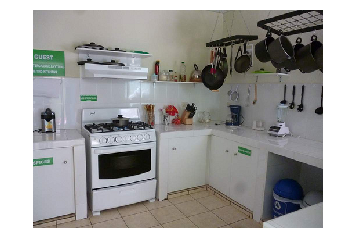

a               0.0017491065664216876
white           0.7070137858390808
kitchen         0.9860542416572571
with            0.999717652797699
green           0.999697208404541
<UNK>           0.9999456405639648
and             0.9998643398284912
hanging         0.9999110698699951
pots            0.999941349029541
<END>           0.9999895095825195
- - - -
Avg reward:  0.701596


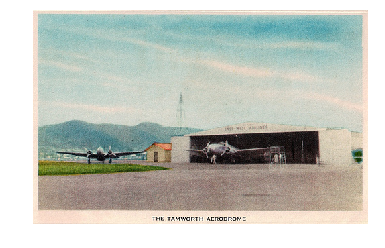

an              0.9429404139518738
airplane        0.08488278090953827
sits            0.07224616408348083
in              0.30287206172943115
the             0.7261508703231812
<UNK>           0.913338840007782
in              0.9876198768615723
this            0.9886149168014526
<UNK>           0.9973852038383484
<END>           0.9999092817306519
- - - -
Avg reward:  0.989263


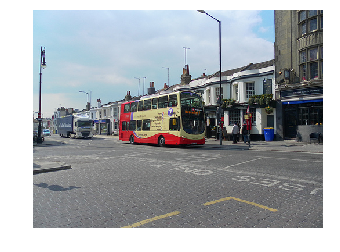

a               0.9705068469047546
double          0.9351062178611755
decker          0.9987718462944031
bus             0.999882698059082
going           0.9999910593032837
down            0.9999527931213379
the             0.9998863935470581
street          0.9992801547050476
<END>           0.9999927282333374
- - - -
Avg reward:  0.819218


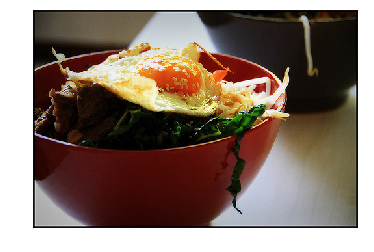

a               7.926530088298023e-05
brown           0.0025949047412723303
bowl            0.8488911390304565
that            0.9898149967193604
has             0.996828019618988
an              0.9943336248397827
assortment      0.9992635846138
of              0.9995700716972351
food            0.9996324777603149
in              0.9997084736824036
it              0.999911904335022
<END>           0.9999871253967285
- - - -
Avg reward:  0.294331


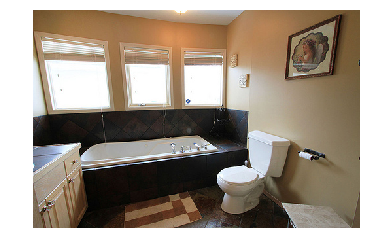

a               0.0009176627499982715
close           0.9768162965774536
up              0.9895109534263611
of              0.9340336918830872
a               0.9209325313568115
bowl            0.00011436323984526098
of              3.993598511442542e-05
<UNK>           0.003007760038599372
bananas         5.2371047786436975e-05
and             0.0005945845041424036
ice             5.319105912349187e-05
cream           0.0002272395940963179
<END>           4.04101319873007e-06
- - - -
Avg reward:  0.00968678


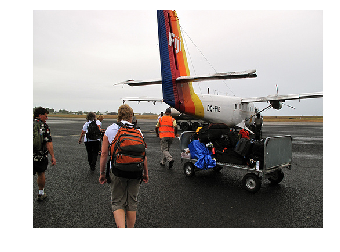

a               0.0743335708975792
kitchen         2.642763683979865e-05
with            0.00038782978663221
a               0.0014625381445512176
table           6.574516737600788e-05
chairs          0.0023914864286780357
and             0.006462717894464731
pots            0.0019157195929437876
<END>           0.00013502765796147287
- - - -
Avg reward:  0.914783


a               0.45227253437042236
large           0.9103469848632812
double          0.9835642576217651
decker          0.971004068851471
bus             0.8712903261184692
is              0.9711442589759827
stopped         0.9081125259399414
at              0.9986867308616638
an              0.9989468455314636
intersection    0.9972445964813232
<END>           0.9999970197677612
- - - -
Avg reward:  0.98114


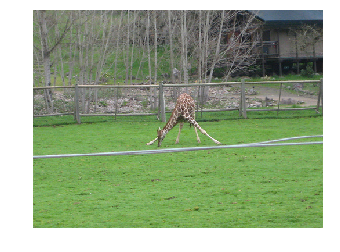

an              0.9999861717224121
airplane        0.7814263701438904
flying          0.9977594614028931
through         0.9995761513710022
the             0.9998352527618408
sky             0.999426007270813
<UNK>           0.9998883008956909
out             0.9997596144676208
lots            0.9994702935218811
of              0.9975624084472656
smoke           0.9990818500518799
<END>           0.9999114274978638
- - - -
Avg reward:  0.501549


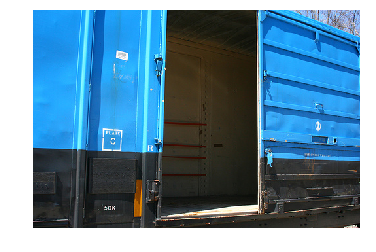

a               0.9987964630126953
<UNK>           0.9912247061729431
room            0.8733550310134888
with            0.7845735549926758
a               0.7207840085029602
hole            0.25926148891448975
in              0.11339151114225388
the             0.1471487432718277
floor           0.10243778675794601
<END>           0.024514539167284966
- - - -


-0.15669915

In [15]:
examine_validation(5, to_examine=True)


#### Bidirectional with tanh doesn't do well, it seems to assign all the tokens in that category (all 1 or all neg 1) after 600 iter / 2000 bath size
#### Bidirectional without tanh seems to do qualitatively better - needs a metric that can compare across different methods
#### Uni-directional with difference of hidden states make results more discriminative at word levels
#### Bidirectional with difference of hidden states are also more disciminative

#### Removing first start token makes good difference. To redo experiments. Initial results after 100 iter/ 1000 batch size per each demo/sample

Avg reward:  0.0956846


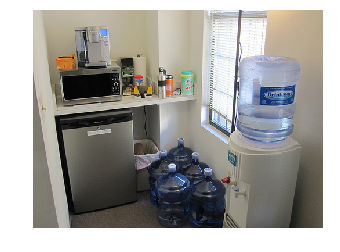

attached        0.014773686416447163
full            0.9234541654586792
soup            0.01374162919819355
narrow          0.0004204609722364694
turn            0.00013925739040132612
steps           2.063760803139303e-05
wide            1.0156040843867231e-05
surfers         6.806520104873925e-05
with            0.003390749916434288
beautiful       0.000827680341899395
- - - -
Avg reward:  0.951915


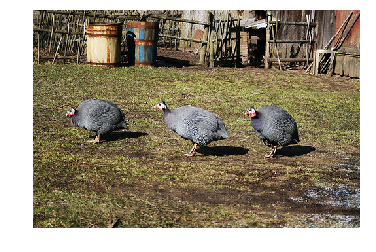

walking         0.9999946355819702
jumping         0.9730592966079712
herd            0.9998321533203125
elephants       0.9992939233779907
like            0.9994584918022156
male            0.7895253300666809
inside          0.9997497200965881
style           0.9995582699775696
box             0.998058021068573
boys            0.7606174349784851
- - - -
Avg reward:  0.00898106


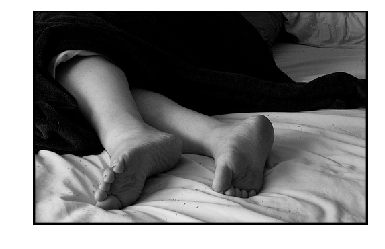

buildings       0.07356283813714981
leather         0.00451075192540884
winter          0.0003511301474645734
waiting         2.4850573026924394e-05
birds           1.0756778010545531e-06
fly             7.946878213260788e-06
living          0.00017777446191757917
wide            0.0003831047797575593
watches         0.0018100689630955458
- - - -
Avg reward:  0.131598


drives          0.5646345019340515
high            0.8777254223823547
flies           0.0001985395938390866
laptops         4.4048792915418744e-05
animals         1.7274152241952834e-07
does            3.001125151058659e-06
case            0.00044735867413692176
two             0.0002974300005007535
kid             0.0004790512612089515
standing        0.0009286799468100071
dirty           0.0028207560535520315
- - - -
Avg reward:  0.0928134


himself         0.8493586778640747
sticking        0.06981376558542252
buildings       0.00015414966037496924
prepared        0.0006211296422407031
tomato          2.4023536298045656e-06
bun             0.0004619124229066074
coming          0.002389246365055442
bird            1.8685734630707884e-06
multiple        2.4950473743956536e-05
eggs            0.00530624482780695
- - - -


In [16]:

img_idx = np.random.choice(val_data.image_idx, 5)
captions = [random_sentence()[0] for _ in range(len(img_idx))]
_ = assign_reward(sess, discr, val_data, img_idx, captions)